# Hierarchical clustering for portfolio optimization


In finance, hierarchical clustering is used, among others, to take advantage of hierarchical relationships in order to diversify risk.


### Dataset description

We retrieve SP500 constituents prices for 2015-2023, this does not consider index rebalancing, it considers the constituents as of 2024, however this does not necessarily distort the analysis, as the goal is to test the divergence in returns between an equally weighted portfolio and a hierarchical risk parity portfolio

# Conclusion
The use of hierarchical clustering for portfolio optimization, specifically through the HRP method, demonstrated a clear advantage over simpler, equally weighted portfolio strategies. This project showcased how advanced statistical techniques could be effectively applied to enhance portfolio performance and risk management in financial markets. By adapting the hierarchical relationships within asset classes, HRP helps in distributing risk more evenly and capitalizing on diversification benefits that are not readily apparent through traditional asset allocation methods. After running a 100 experiments we achieve a mean increase in Sharpe of 0.02 in Sharpe, with up to 0.09 of increase possible. 

# Visual Representation and Documentation
The project included detailed visualizations to compare the cumulative returns and drawdown periods between the HRP-optimized portfolio and the equally weighted portfolio.
All analyses and findings were systematically documented in a Jupyter Notebook, making the study transparent and reproducible.



## Initial setup and modules/packages loading

In [44]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy.cluster.vq import whiten
import riskfolio as rp
from scipy.stats import norm


In [45]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [46]:

# Fetch the S&P 500 table from Wikipedia
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
sp500_tickers = df['Symbol'].tolist()

# Sometimes you need to adjust tickers, e.g., replace '.' with '-' for Yahoo Finance compatibility
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

# Now you can use `sp500_tickers` with `yfinance` as shown above


In [47]:
import yfinance as yf
import pandas as pd

# Example: Manually define a small list of S&P 500 tickers
# In practice, you might load this from a file or another source

# Fetch historical data for these tickers
data = yf.download(sp500_tickers, start="2015-01-01", end="2023-01-01")


[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['VLTO', 'KVUE', 'GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1672549200")


In [48]:
data['Adj Close'][sp500_tickers[0:20]]

Ticker,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,93.579033,24.154341,37.481434,44.314438,75.950928,72.339996,2.670000,9.882956,24.433512,37.551186,107.641777,NaN,63.250000,53.082985,67.403481,56.200001,49.954624,24.566343,57.149815,26.477501
2015-01-05,91.468567,23.731718,37.489780,43.480476,74.668541,71.980003,2.660000,9.601614,23.793470,36.847569,104.200012,NaN,61.939999,51.322655,68.214211,56.990002,49.854801,24.267113,56.016914,25.973000
2015-01-06,90.493187,23.537661,37.064049,43.265255,74.129951,70.529999,2.630000,9.385200,23.581459,36.273563,104.163010,NaN,60.669998,50.319256,68.559525,57.450001,49.773136,24.189539,55.976158,25.332001
2015-01-07,91.149147,23.710150,37.364567,45.013893,75.685898,71.110001,2.580000,9.399629,23.729462,36.754997,105.288078,NaN,60.160000,50.116821,69.490364,59.570000,50.453716,24.588507,56.897141,25.257500
2015-01-08,93.333755,24.326845,38.132565,45.484673,76.840034,72.919998,2.610000,9.543905,23.961481,37.856701,107.723198,NaN,61.570000,51.692322,70.286079,61.439999,51.134300,24.976391,57.989300,25.345501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,91.802177,55.438164,105.027542,153.846542,259.968933,338.450012,64.519997,27.221605,69.667442,147.692978,300.622833,85.250000,83.160004,224.287079,138.359940,203.669998,102.976059,52.400810,131.581833,89.230003
2022-12-27,91.863304,56.188381,105.406174,153.742783,259.206848,335.089996,63.270000,27.354486,70.143219,148.009689,300.776947,83.489998,83.500000,211.637802,137.617599,204.589996,103.907478,53.092537,131.244125,87.389999
2022-12-28,90.388542,55.311508,104.687729,153.025879,257.067230,328.329987,62.570000,26.879913,69.395576,146.564713,298.310577,82.489998,83.500000,211.519211,134.798523,201.580002,102.279945,52.315529,130.674820,86.019997


# Helper functions

In [49]:
# Helper functions
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns, periods_per_year to be inferred
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualize the volatility of a set of returns.

    Parameters:
    - r (pd.Series): The set of periodic returns. It can be daily, monthly, etc.
    - periods_per_year (int): The number of periods in one year. E.g., 252 for daily, 12 for monthly.

    Returns:
    - float: The annualized volatility or standard deviation of the return series.
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, rf_daily_returns, periods_per_year):
    """
    r: Daily returns of the fund for which you are calculating the Sharpe Ratio
    rf_daily_returns: Daily returns of Fund A (which you're using as the risk-free rate)
    periods_per_year: Number of trading days in a year (commonly used value is 252 for stocks)
    """

    # Convert daily risk-free returns to annual risk-free rate
    annual_rf = (1 + rf_daily_returns).prod()**(periods_per_year/len(rf_daily_returns)) - 1

    # Calculate excess returns
    excess_ret = r - annual_rf/periods_per_year  # Subtracting the daily equivalent risk-free rate

    # Calculate annualized excess return
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)

    # Calculate annualized volatility
    ann_vol = annualize_vol(r, periods_per_year)

    return ann_ex_ret/ann_vol

def summary_stats(r, rf_daily_returns=0):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=252)
    ann_rf = rf_daily_returns.aggregate(annualize_rets, periods_per_year=252) if rf_daily_returns else 0 
    ann_excess_r = ann_r - ann_rf  # Annualized Excess Return

    ann_vol = r.aggregate(annualize_vol, periods_per_year=252)

    sharpe_r = ann_excess_r / ann_vol if ann_vol != 0 else np.nan  # Sharpe Ratio

    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)

    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Excess Return": ann_excess_r,
        "Annualized Vol": ann_vol,
        "Sharpe Ratio": sharpe_r,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Max Drawdown": dd
    }, index=[r.name])
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4
def var_historic(r, level=5):
    """VaR Historic"""
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=5)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for the wealth index, the previous peaks, and  the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    return pd.DataFrame({"Wealth": wealth_index,"Previous Peak": previous_peaks,"Drawdown": drawdowns})

## Data understanding

In [50]:
# Load dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Columns: 3018 entries, ('Adj Close', 'A') to ('Volume', 'ZTS')
dtypes: float64(2543), int64(475)
memory usage: 46.4 MB


In [51]:
# Summary statistics
data.describe(include='all').T

count          mean           std            min  \
Price     Ticker                                                      
Adj Close A       2014.0  7.929629e+01  3.790564e+01      31.138296   
          AAL     2014.0  3.112630e+01  1.266301e+01       9.040000   
          AAPL    2014.0  7.090637e+01  4.916664e+01      20.772156   
          ABBV    2014.0  7.426752e+01  3.087296e+01      33.530453   
          ABNB     518.0  1.464226e+02  3.158488e+01      82.489998   
...                  ...           ...           ...            ...   
Volume    XYL     2014.0  1.092809e+06  5.172875e+05  184600.000000   
          YUM     2014.0  2.726957e+06  2.444704e+06  340400.000000   
          ZBH     2014.0  1.365537e+06  7.321107e+05  240505.000000   
          ZBRA    2014.0  4.519843e+05  4.062849e+05   81000.000000   
          ZTS     2014.0  2.554297e+06  1.376228e+06  417400.000000   

                           25%           50%           75%           max  
Price     Ticker                                                          
Adj Close A       4.504957e+01  6.729650e+01  1.146034e+02  1.760851e+02  
          AAL     1.877500e+01  3.245167e+01  4.155598e+01  5.698873e+01  
          AAPL    2.920591e+01  4.605337e+01  1.215834e+02  1.797245e+02  
          ABBV    4.718199e+01  6.952439e+01  9.119880e+01  1.604933e+02  
          ABNB    1.167125e+02  1.505100e+02  1.699850e+02  2.168400e+02  
...                        ...           ...           ...           ...  
Volume    XYL     7.363250e+05  9.804000e+05  1.321100e+06  5.052400e+06  
          YUM     1.461625e+06  2.001150e+06  3.139242e+06  5.110631e+07  
          ZBH     9.226482e+05  1.196963e+06  1.591891e+06  1.037962e+07  
          ZBRA    2.728500e+05  3.702500e+05  5.217750e+05  1.157870e+07  
          ZTS     1.673850e+06  2.219450e+06  3.028425e+06  2.082330e+07  

[3018 rows x 8 columns]

In [52]:
# Check which rows have missing values
data[data.isnull().any(axis=1)]

Price        Adj Close                                                \
Ticker               A        AAL        AAPL        ABBV       ABNB   
Date                                                                   
2015-01-02   37.551186  51.079903   24.435268   44.314438        NaN   
2015-01-05   36.847569  51.051483   23.746891   43.480476        NaN   
2015-01-06   36.273563  50.255589   23.749121   43.265255        NaN   
2015-01-07   36.754997  50.227158   24.082136   45.013893        NaN   
2015-01-08   37.856701  50.843037   25.007427   45.484673        NaN   
...                ...        ...         ...         ...        ...   
2022-12-23  147.692978  12.710000  130.959961  153.846542  85.250000   
2022-12-27  148.009689  12.530000  129.142426  153.742783  83.489998   
2022-12-28  146.564713  12.320000  125.179680  153.025879  82.489998   
2022-12-29  149.533798  12.700000  128.725296  153.337173  85.230003   
2022-12-30  148.329529  12.720000  129.043106  152.441055  85.500000   

Price                                                                  ...  \
Ticker             ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2015-01-02   37.481434  19.496668   75.950928   72.339996   45.635750  ...   
2015-01-05   37.489780  19.379999   74.668541   71.980003   44.805847  ...   
2015-01-06   37.064049  19.423332   74.129951   70.529999   43.754097  ...   
2015-01-07   37.364567  19.536667   75.685898   71.110001   44.214252  ...   
2015-01-08   38.132565  19.876667   76.840034   72.919998   44.994835  ...   
...                ...        ...         ...         ...         ...  ...   
2022-12-23  105.027542  63.380001  259.968933  338.450012  160.024170  ...   
2022-12-27  105.406174  63.619999  259.206848  335.089996  158.422363  ...   
2022-12-28  104.687729  62.599998  257.067230  328.329987  156.547089  ...   
2022-12-29  107.095467  63.110001  262.206268  337.579987  160.160904  ...   
2022-12-30  106.590614  62.779999  260.701691  336.529999  160.209747  ...   

Price       Volume                                                         \
Ticker         WTW       WY     WYNN      XEL       XOM      XYL      YUM   
Date                                                                        
2015-01-02  209022  2426600  2228900  2534900  10220400   605900  2283466   
2015-01-05  343789  2385400  1695100  3107200  18502400  1369900  4418651   
2015-01-06  347338  3405900  1975800  4749600  16670700  1333200  5004401   
2015-01-07  348357  2872700  1472000  2833400  13590700  1038600  4554134   
2015-01-08  343147  3004500  1676600  2516800  15487500   821800  4258268   
...            ...      ...      ...      ...       ...      ...      ...   
2022-12-23  251400  1932800  1134800  1201300  11539400   321100   700800   
2022-12-27  248500  2266000  4026500  1580600  11962100   468200  1300200   
2022-12-28  257200  2244100  2131500  1513700  10702100   480400   964800   
2022-12-29  245500  1846000  1431100  1398000  10534000   516300   875700   
2022-12-30  221200  3166600  1614700  1597000  11799600   548900  1401300   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2015-01-02   936579  411800  1784200  
2015-01-05  2223873  420300  3112100  
2015-01-06  1835563  527500  3977200  
2015-01-07  1505860  467800  2481800  
2015-01-08  1449004  324400  3121300  
...             ...     ...      ...  
2022-12-23   789800  180900  1017900  
2022-12-27   755600  252500   957900  
2022-12-28   750100  241200  1443900  
2022-12-29   686600  274900  1298900  
2022-12-30   785200  228200  1249500  

[2014 rows x 3018 columns]

## Data preparation

In [53]:
# Calculate the percentage change
import pandas as pd

# Assuming df is your DataFrame
# Fill NaN with the average of each column
X = data['Adj Close'].pct_change().iloc[1:].apply(lambda x: x.fillna(x.mean()), axis=1)


C:\Users\ahmed\AppData\Local\Temp\ipykernel_12296\2579416714.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  X = data['Adj Close'].pct_change().iloc[1:].apply(lambda x: x.fillna(x.mean()), axis=1)


In [54]:
X.describe()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,...,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,0.000824,-0.000140,0.001005,0.000768,0.000411,0.000640,0.000729,0.000739,0.000979,0.000827,...,0.000544,0.000305,0.000330,0.000543,0.000436,0.000732,0.000650,0.000268,0.000918,0.000770
std,0.016771,0.033523,0.018865,0.017475,0.021327,0.015513,0.017174,0.015910,0.020713,0.020120,...,0.015328,0.021110,0.033373,0.013569,0.018265,0.017392,0.015960,0.017906,0.025307,0.016563
min,-0.110117,-0.252246,-0.128647,-0.162524,-0.134250,-0.097857,-0.168752,-0.083899,-0.167932,-0.166149,...,-0.092248,-0.226734,-0.244346,-0.126919,-0.122248,-0.120272,-0.188324,-0.139943,-0.238459,-0.146956
25%,-0.007182,-0.015218,-0.007568,-0.007138,-0.005760,-0.006227,-0.006209,-0.006286,-0.007466,-0.008897,...,-0.006241,-0.008737,-0.015883,-0.005862,-0.008184,-0.007439,-0.005868,-0.007729,-0.010763,-0.007039
50%,0.001318,-0.000548,0.000765,0.001319,0.000799,0.000824,0.001116,0.001316,0.001673,0.000971,...,0.000794,0.000666,-0.001099,0.000940,0.000234,0.000594,0.000750,0.000166,0.000995,0.000941
75%,0.009810,0.014721,0.010355,0.008855,0.006978,0.008965,0.007934,0.008171,0.010853,0.010679,...,0.007538,0.010081,0.015156,0.007638,0.008852,0.009482,0.007403,0.008609,0.012585,0.009004
max,0.098394,0.410970,0.119808,0.137673,0.133418,0.109360,0.153577,0.128573,0.177193,0.146977,...,0.151057,0.253155,0.276883,0.112577,0.126868,0.112619,0.232484,0.155798,0.172142,0.119793


In [55]:
X.isna().sum()

Ticker
A       0
AAL     0
AAPL    0
ABBV    0
ABNB    0
       ..
XYL     0
YUM     0
ZBH     0
ZBRA    0
ZTS     0
Length: 503, dtype: int64

## Modeling

# Hierarchical Risk Parity

In [ ]:
X_in.columns[0::]

In [149]:
random_select

array(['EVRG', 'MSI', 'SNA', 'K', 'FOXA', 'AXON', 'QRVO', 'EXPE', 'LLY',
       'DFS', 'CNP', 'BBWI', 'JBL', 'OKE', 'TJX', 'CMCSA', 'TFC', 'PNW',
       'FANG', 'MAA', 'ZTS', 'CLX', 'CTSH', 'AKAM', 'AAL', 'DRI', 'WTW',
       'ZBH', 'MKTX', 'EOG', 'VZ', 'BALL', 'RVTY', 'DVN', 'NKE', 'CFG',
       'GEHC', 'DG', 'SO', 'AEP', 'DD', 'USB', 'HSY', 'MPC', 'TSLA',
       'DECK', 'AMGN', 'STT', 'ABT', 'APD', 'TXT', 'INTU', 'ILMN', 'RTX',
       'CL', 'VRSK', 'RSG', 'FIS', 'TRGP', 'YUM', 'NRG', 'JNJ', 'WY',
       'XEL', 'LIN', 'CE', 'BDX', 'META', 'MRK', 'KVUE', 'TT', 'BR', 'HD',
       'JPM', 'CVS', 'KEY', 'GM', 'AJG', 'TYL', 'XOM', 'DXCM', 'NFLX',
       'DE', 'WRB', 'SHW', 'MTD', 'SOLV', 'JCI', 'VTRS', 'PFG', 'VICI',
       'WDC', 'FTV', 'CHD', 'BBY', 'VRSN', 'PCG', 'AZO', 'COR', 'WM'],
      dtype=object)

In [176]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt

sharpe_differences = []
num_experiments = 100
for _ in range(num_experiments):
    # Assuming X is your DataFrame where the index is dates and columns are assets
    random_select = np.random.choice(X.columns, size=100, replace=False)

    # Step 1: Split Data into In-Sample and Out-of-Sample
    split_date = '2018-01-05'  # The specific split date
    X_in = X[X.index <= split_date][random_select]
    X_out = X[X.index > split_date][random_select]

    # Define a threshold
    threshold = 1e-4 # Adjust this based on your specific data scale and requirements

    # Set values smaller than the threshold to zero
    X_in = X_in.applymap(lambda x: 0 if abs(x) < threshold else x)

    # Step 2: Optimize Portfolio Using In-Sample Data
    port_in = rp.HCPortfolio(returns=X_in)
    w_in = port_in.optimization(model='HRP', rm='MDD', rf=0, linkage='ward', max_k=50, leaf_order=True)

    # Step 3: Calculate Returns of Optimized Portfolio Out-of-Sample
    returns_in_optimized = (X_in * w_in['weights'].T).sum(axis=1)
    returns_out_optimized = (X_out * w_in['weights'].T).sum(axis=1)

    # Step 4: Construct and Calculate Returns of Equally Weighted Portfolio
    n_assets = X[random_select].shape[1]
    equal_weights = np.repeat(1/n_assets, n_assets)
    returns_in_equal = (X_in * equal_weights).sum(axis=1)
    returns_out_equal = (X_out * equal_weights).sum(axis=1)

    # Combine the returns into a single DataFrame
    returns_optimized = pd.concat([returns_in_optimized, returns_out_optimized])
    returns_equal = pd.concat([returns_in_equal, returns_out_equal])

    combined_returns = pd.DataFrame({
        'Optimized Portfolio': returns_optimized,
        'Equally Weighted Portfolio': returns_equal
    })

    # Marking the out-of-sample period
    combined_returns['Period'] = 'In-Sample'
    combined_returns.loc[combined_returns.index > split_date, 'Period'] = 'Out-of-Sample'


    # Calculate summary statistics for both portfolios
    returns_out_optimized_summary_stats = summary_stats(returns_out_optimized)
    returns_out_equal_summary_stats = summary_stats(returns_out_equal)
    sharpe_differences.append(returns_out_optimized_summary_stats['Sharpe Ratio'][0] - returns_out_equal_summary_stats['Sharpe Ratio'][0])


C:\Users\ahmed\AppData\Local\Temp\ipykernel_12296\2687493205.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_in = X_in.applymap(lambda x: 0 if abs(x) < threshold else x)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12296\2687493205.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sharpe_differences.append(returns_out_optimized_summary_stats['Sharpe Ratio'][0] - returns_out_equal_summary_stats['Sharpe Ratio'][0])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12296\2687493205.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_in = X_in.applymap(lambda x: 0 if abs(x) < threshold else x)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12296\2687493205.py:54: FutureWarning: Series.__getitem__ treating keys as positions is d

In [177]:
pd.DataFrame(np.array(sharpe_differences)).describe()

,0
count,100.000000
mean,0.023871
std,0.033554
min,-0.071413
25%,0.005090
50%,0.025488
75%,0.047598
max,0.097357


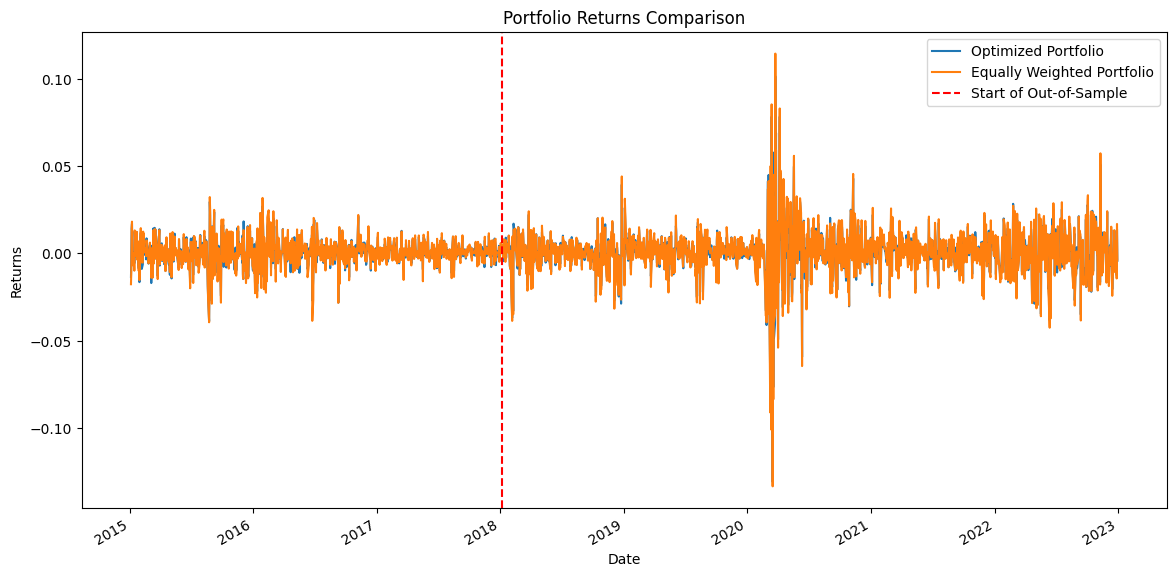

In [178]:
# Plotting the returns of a given example
fig, ax = plt.subplots(figsize=(14, 7))
combined_returns['Optimized Portfolio'].plot(ax=ax, label='Optimized Portfolio')
combined_returns['Equally Weighted Portfolio'].plot(ax=ax, label='Equally Weighted Portfolio')
ax.axvline(x=split_date, color='r', linestyle='--', label='Start of Out-of-Sample')
ax.set_title('Portfolio Returns Comparison')
ax.set_ylabel('Returns')
ax.legend()
plt.show()


Optimized portfolio seems to have less volatility 

In [179]:
# Calculate summary statistics for both portfolios
returns_out_optimized_summary_stats = summary_stats(returns_out_optimized)
returns_out_equal_summary_stats = summary_stats(returns_out_equal)

In [180]:
pd.concat([returns_out_optimized_summary_stats, returns_out_equal_summary_stats])

,Annualized Return,Annualized Excess Return,Annualized Vol,Sharpe Ratio,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Max Drawdown
None,0.126202,0.126202,0.211541,0.596582,-0.713034,20.247317,0.019285,-0.376076
None,0.123817,0.123817,0.230148,0.537987,-0.617139,18.097390,0.021292,-0.395862


In [162]:
returns_out_optimized_summary_stats['Sharpe Ratio'][0] - returns_out_equal_summary_stats['Sharpe Ratio'][0]

C:\Users\ahmed\AppData\Local\Temp\ipykernel_12296\4291487991.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns_out_optimized_summary_stats['Sharpe Ratio'][0] - returns_out_equal_summary_stats['Sharpe Ratio'][0]


0.025406557789353412

<Axes: title={'center': 'Sharpe Ratio - OOS'}>

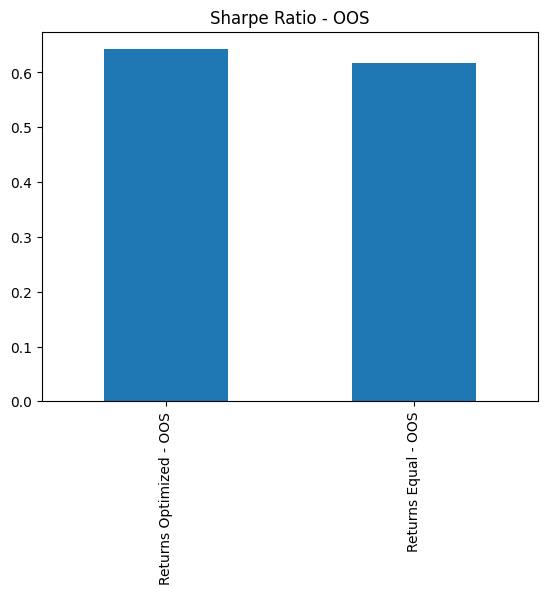

In [144]:
pd.concat([returns_out_optimized_summary_stats, returns_out_equal_summary_stats])['Sharpe Ratio'].plot(kind='bar', title='Sharpe Ratio - OOS')

<Axes: title={'center': 'Return statistics - OOS'}>

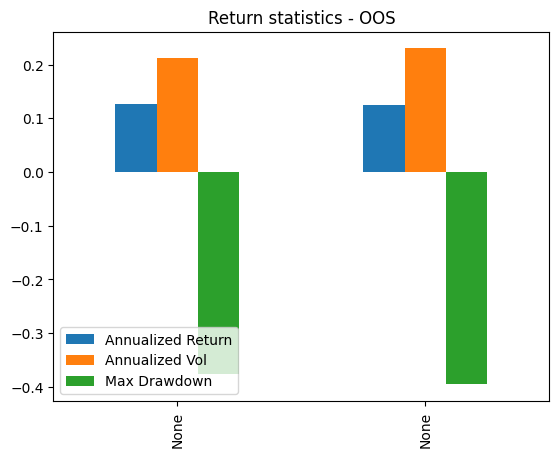

In [181]:
pd.concat([returns_out_optimized_summary_stats, returns_out_equal_summary_stats])[['Annualized Return', 'Annualized Vol', 'Max Drawdown']].plot(kind='bar', title='Return statistics - OOS')

In [ ]:
# Lower drawdown, lower vol, better return

<Axes: >

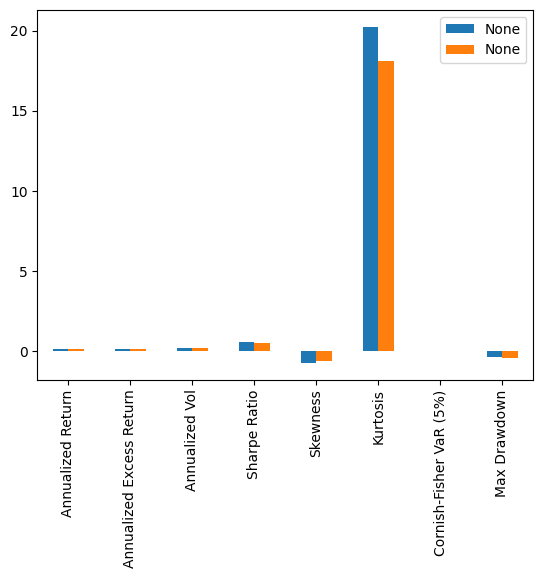

In [182]:
pd.concat([returns_out_optimized_summary_stats, returns_out_equal_summary_stats]).T.plot(kind='bar')

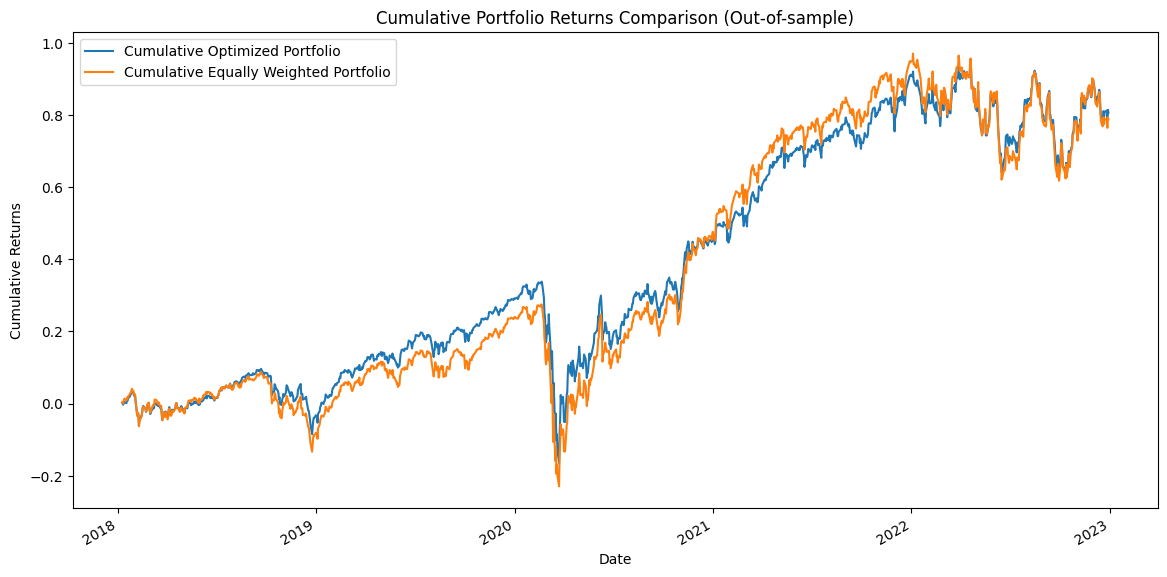

In [183]:
# Calculate Cumulative Returns
returns_out_optimized['Cumulative Optimized'] = (1 + returns_out_optimized).cumprod() - 1
returns_out_equal['Cumulative Equal'] = (1 + returns_out_equal).cumprod() - 1

# Plotting Cumulative Returns
fig, ax = plt.subplots(figsize=(14, 7))
returns_out_optimized['Cumulative Optimized'].plot(ax=ax, label='Cumulative Optimized Portfolio')
returns_out_equal['Cumulative Equal'].plot(ax=ax, label='Cumulative Equally Weighted Portfolio')
ax.set_title('Cumulative Portfolio Returns Comparison (Out-of-sample)')
ax.set_ylabel('Cumulative Returns')
ax.legend()
plt.show()

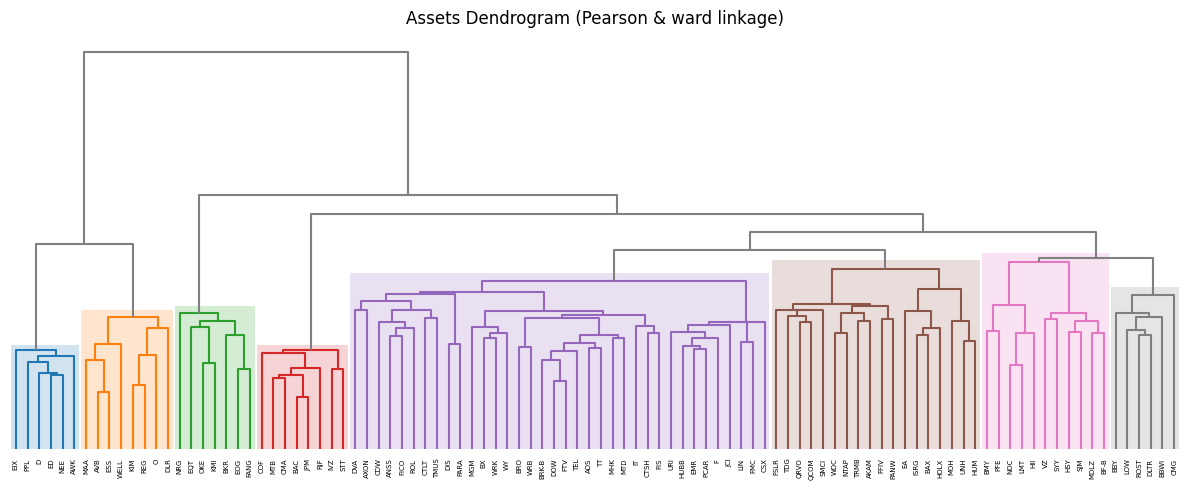

In [184]:
# Plot the dendogram

# Draw
fig, ax = plt.subplots(figsize=(10,10))
dg = rp.plot_dendrogram(returns=X_in,
                               codependence='pearson',
                               linkage='ward',
                               k=None,
                               max_k=10,
                               leaf_order=True)